In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import os

from utils import read_geo

In [2]:
class FrameElement3D:
    def __init__(self, node_indices, node_coordinates, E, A, L, I_y, I_z, J, theta_x=0):
        self.node_indices = node_indices
        self.node_coordinates = node_coordinates
        self.E = E
        self.A = A
        self.L = L
        self.I_y = I_y  
        self.I_z = I_z  
        self.J = J     
        self.theta_x = theta_x # Rotation about local x-axis (roll/beta angle)
        self.k_elem_local = None 
        self.T = None # Transformation matrix

    def get_local_stiffness_matrix(self):
        E, A, L, I_y, I_z, J = self.E, self.A, self.L, self.I_y, self.I_z, self.J

        k_axial = E * A / L

        k_torsion = E * J / L 

        k_bending_y1 = 12 * E * I_y / L**3
        k_bending_y2 = 6 * E * I_y / L**2
        k_bending_y3 = 4 * E * I_y / L
        k_bending_y4 = 2 * E * I_y / L

        k_bending_z1 = 12 * E * I_z / L**3
        k_bending_z2 = 6 * E * I_z / L**2
        k_bending_z3 = 4 * E * I_z / L
        k_bending_z4 = 2 * E * I_z / L

        # Construct the 12x12 local stiffness matrix
        # Columns/Rows order: Node1(ux,uy,uz,rx,ry,rz), Node2(ux,uy,uz,rx,ry,rz)
        self.k_elem_local = np.array([
            # Node 1 DOFs (ux1, uy1, uz1, rx1, ry1, rz1)
            [k_axial,        0,                 0,                 0,                  0,                 0,                -k_axial,         0,                 0,                 0,                  0,                 0],  # ux1
            [0,                k_bending_z1,      0,                 0,                  0,                 k_bending_z2,     0,               -k_bending_z1,     0,                 0,                  0,                 k_bending_z2],  # uy1
            [0,                0,                 k_bending_y1,      0,                  -k_bending_y2,     0,                0,                 0,                -k_bending_y1,      0,                  -k_bending_y2,     0],  # uz1
            [0,                0,                 0,                 k_torsion,          0,                 0,                0,                 0,                 0,                -k_torsion,         0,                 0],  # rx1
            [0,                0,                -k_bending_y2,      0,                  k_bending_y3,      0,                0,                 0,                 k_bending_y2,       0,                  k_bending_y4,      0],  # ry1
            [0,                k_bending_z2,      0,                 0,                  0,                 k_bending_z3,     0,               -k_bending_z2,     0,                 0,                  0,                 k_bending_z4],  # rz1
            # Node 2 DOFs (ux2, uy2, uz2, rx2, ry2, rz2)
            [-k_axial,       0,                 0,                 0,                  0,                 0,                k_axial,          0,                 0,                 0,                  0,                 0],  # ux2
            [0,               -k_bending_z1,     0,                 0,                  0,                -k_bending_z2,     0,                k_bending_z1,      0,                 0,                  0,                -k_bending_z2],  # uy2
            [0,                0,                -k_bending_y1,      0,                  k_bending_y2,      0,                0,                 0,                 k_bending_y1,       0,                  k_bending_y2,      0],  # uz2
            [0,                0,                 0,                -k_torsion,         0,                 0,                0,                 0,                 0,                 k_torsion,          0,                 0],  # rx2
            [0,                0,                 k_bending_y2,       0,                  k_bending_y4,      0,                0,                 0,                -k_bending_y2,       0,                  k_bending_y3,      0],  # ry2
            [0,               -k_bending_z2,     0,                 0,                  0,                 k_bending_z4,     0,                k_bending_z2,      0,                 0,                  0,                 k_bending_z3]   # rz2
        ])
        return self.k_elem_local

    def get_global_stiffness_matrix(self):
        self.get_local_stiffness_matrix()

        x1, y1, z1 = self.node_coordinates[0]
        x2, y2, z2 = self.node_coordinates[1]

        # Calculate direction cosines of the element's local x-axis (from node1 to node2)
        dx, dy, dz = x2 - x1, y2 - y1, z2 - z1
        L = np.sqrt(dx**2 + dy**2 + dz**2)

        if L == 0:
            raise ValueError(f"Element {self.node_indices} has zero length.")

        Cx, Cy, Cz = dx / L, dy / L, dz / L

        # Construct the 3x3 rotation matrix R (global to local coordinates).
        # This aligns the element's local x-axis (from node1 to node2) with the global axes.
        # The orientation of the local y and z axes is defined by the 'theta_x' (beta) angle.

        # Case 1: Element is not vertical (Cz is not close to 1 or -1)
        if abs(Cz) < 0.99999:
            # Intermediate vector for defining local y-axis projection in XY plane
            Dx = -Cy
            Dy = Cx
            Dz = 0.0
            Dl = np.sqrt(Dx**2 + Dy**2)
            Dx /= Dl
            Dy /= Dl

            # Unit vector along local x-axis
            lambda_x = np.array([Cx, Cy, Cz])

            # Unit vector along intermediate local y-axis (perpendicular to x_l, generally in XY plane)
            lambda_y_prime = np.array([Dx, Dy, Dz])

            # Unit vector along intermediate local z-axis (cross product of x_l and y_prime)
            lambda_z_prime = np.cross(lambda_x, lambda_y_prime)

            # Apply the beta angle (theta_x) rotation for final local y and z axes
            cos_beta = np.cos(np.deg2rad(self.theta_x))
            sin_beta = np.sin(np.deg2rad(self.theta_x))

            lambda_y = cos_beta * lambda_y_prime + sin_beta * lambda_z_prime
            lambda_z = -sin_beta * lambda_y_prime + cos_beta * lambda_z_prime
        else: # Case 2: Element is vertical (Cz is close to 1 or -1)
            lambda_x = np.array([Cx, Cy, Cz])
            # If vertical, local y-axis can be aligned with global Y, then rotated by beta
            # Or, more robustly, align with a vector perpendicular to local x-axis (e.g., global Y)
            # and then apply beta rotation.
            cos_beta = np.cos(np.deg2rad(self.theta_x))
            sin_beta = np.sin(np.deg2rad(self.theta_x))

            # If Cz is 1, lambda_x = [0,0,1]. We need a y-axis. Use global Y rotated by beta.
            # If Cz is -1, lambda_x = [0,0,-1].
            if Cz > 0: # Points upwards
                lambda_y = np.array([-sin_beta, cos_beta, 0.0])
            else: # Points downwards
                lambda_y = np.array([sin_beta, -cos_beta, 0.0]) # Adjust for downwards element
            lambda_z = np.cross(lambda_x, lambda_y)

        # The 3x3 rotation matrix R (global to local)
        R_3x3 = np.array([lambda_x, lambda_y, lambda_z])

        # Construct the 6x6 transformation matrix for a single node (translations and rotations)
        R_block = np.block([[R_3x3, np.zeros((3,3))],
                            [np.zeros((3,3)), R_3x3]])

        self.T = np.block([[R_block, np.zeros((6,6))],
                           [np.zeros((6,6)), R_block]])

        self.K_elem_global = self.T.T @ self.k_elem_local @ self.T
        return self.K_elem_global



In [3]:
class FrameSystem3D:
    def __init__(self, elements, num_nodes, forces, boundary_conditions):
        self.elements = elements
        self.num_nodes = num_nodes
        self.forces = forces
        self.boundary_conditions = boundary_conditions
        self.K_global_system = None 
        self.P_global = None       
        self.displacements = None   

    def assemble_global_stiffness_matrix(self):
        # Each node has 6 DOFs (ux, uy, uz, rx, ry, rz)
        total_dofs = self.num_nodes * 6
        self.K_global_system = np.zeros((total_dofs, total_dofs))

        for element in self.elements:
            K_elem_global = element.get_global_stiffness_matrix()
            node1_idx, node2_idx = element.node_indices

            # Define the global DOF indices for the two nodes of the current element
            global_dofs_node1 = np.arange(6 * node1_idx, 6 * node1_idx + 6)
            global_dofs_node2 = np.arange(6 * node2_idx, 6 * node2_idx + 6)

            # Combined global DOF indices for the element (12 DOFs)
            element_global_dofs = np.concatenate((global_dofs_node1, global_dofs_node2))

            # Add element stiffness matrix contributions to the global system matrix
            for i, row_dof in enumerate(element_global_dofs):
                for j, col_dof in enumerate(element_global_dofs):
                    self.K_global_system[row_dof, col_dof] += K_elem_global[i, j]

        return self.K_global_system

    def assemble_global_force_vector(self):
        total_dofs = self.num_nodes * 6
        self.P_global = np.zeros(total_dofs)

        for node_idx, forces_moments in self.forces.items():
            # forces_moments should be [Fx, Fy, Fz, Mx, My, Mz]
            start_dof = node_idx * 6
            self.P_global[start_dof : start_dof + 6] = forces_moments
        return self.P_global

    def apply_boundary_conditions(self):
        total_dofs = self.num_nodes * 6
        active_dofs = [] # List to store indices of DOFs that are NOT fixed

        for dof_idx in range(total_dofs):
            node_idx = dof_idx // 6       # Get the node index
            dof_type_idx = dof_idx % 6    # Get the DOF type index (0:ux, 1:uy, ..., 5:rz)

            if node_idx in self.boundary_conditions:
                if not self.boundary_conditions[node_idx][dof_type_idx]:
                    active_dofs.append(dof_idx)
            else: 
                active_dofs.append(dof_idx)

        # Create reduced stiffness matrix and force vector using the active DOFs
        K_reduced = self.K_global_system[np.ix_(active_dofs, active_dofs)]
        P_reduced = self.P_global[active_dofs]

        return K_reduced, P_reduced, active_dofs

    def solve(self):
        print("Assembling global stiffness matrix...")
        K_global = self.assemble_global_stiffness_matrix()
        print("Assembling global force vector...")
        P_global = self.assemble_global_force_vector()

        print("Applying boundary conditions...")
        K_reduced, P_reduced, active_dofs = self.apply_boundary_conditions()

        if K_reduced.shape[0] == 0:
            print("No free degrees of freedom. Cannot solve for displacements.")
            self.displacements = np.zeros(self.num_nodes * 6)
            return self.displacements

        # Solve for the unknown displacements of the active DOFs
        try:
            print("Solving system of equations...")
            u_reduced = np.linalg.solve(K_reduced, P_reduced)
            print("Solution complete.")
        except np.linalg.LinAlgError:
            print("Error: Stiffness matrix is singular. The structure may be unstable or improperly constrained.")
            self.displacements = None
            return None

        # Expand the reduced displacements back to the full global displacement vector
        total_dofs = self.num_nodes * 6
        self.displacements = np.zeros(total_dofs)
        self.displacements[active_dofs] = u_reduced
        return self.displacements


In [4]:

class Plotter3D:
    def __init__(self, solver):
        self.system = solver
        self.displacements = solver.displacements

    def plot_system(self, scale_factor=500):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        all_initial_coords = {}
        for element in self.system.elements:
            all_initial_coords[element.node_indices[0]] = element.node_coordinates[0]
            all_initial_coords[element.node_indices[1]] = element.node_coordinates[1]

        sorted_node_coords = [all_initial_coords[i] for i in sorted(all_initial_coords.keys())]
        initial_x = [c[0] for c in sorted_node_coords]
        initial_y = [c[1] for c in sorted_node_coords]
        initial_z = [c[2] for c in sorted_node_coords]

        # Plot initial nodes
        ax.scatter(initial_x, initial_y, initial_z, c="r", marker='o', label='Initial Nodes')

        # Plot initial elements (red solid lines)
        for i, element in enumerate(self.system.elements):
            pos1, pos2 = element.node_coordinates
            node_index1, node_index2 = element.node_indices

            x1, y1, z1 = pos1
            x2, y2, z2 = pos2
            ax.plot([x1, x2], [y1, y2], [z1, z2], c="r", linestyle='-', linewidth=1.5, label='Initial Elements' if i == 0 else "")

            # Annotate nodes
            ax.text(x1, y1, z1 + 0.05*self.system.elements[0].L, str(node_index1), color="r", horizontalalignment='center', verticalalignment='bottom')
            ax.text(x2, y2, z2 + 0.05*self.system.elements[0].L, str(node_index2), color="r", horizontalalignment='center', verticalalignment='bottom')

        # Plot system with displacements 
        if self.displacements is not None and len(self.displacements) > 0:
            deformed_node_coords = {}
            for i, element in enumerate(self.system.elements):
                pos1, pos2 = element.node_coordinates
                node_index1, node_index2 = element.node_indices

                dx1, dy1, dz1, drx1, dry1, drz1 = self.displacements[6 * node_index1 : 6 * node_index1 + 6]
                dx2, dy2, dz2, drx2, dry2, drz2 = self.displacements[6 * node_index2 : 6 * node_index2 + 6]

                x1, y1, z1 = pos1
                x2, y2, z2 = pos2

                x1_disp = x1 + dx1 * scale_factor
                y1_disp = y1 + dy1 * scale_factor
                z1_disp = z1 + dz1 * scale_factor

                x2_disp = x2 + dx2 * scale_factor
                y2_disp = y2 + dy2 * scale_factor
                z2_disp = z2 + dz2 * scale_factor

                deformed_node_coords[node_index1] = (x1_disp, y1_disp, z1_disp)
                deformed_node_coords[node_index2] = (x2_disp, y2_disp, z2_disp)

                ax.plot([x1_disp, x2_disp], [y1_disp, y2_disp], [z1_disp, z2_disp],
                        c="b", linestyle="--", linewidth=1.0, label='Deformed Elements (scaled)' if i == 0 else "")

            # Plot deformed nodes
            sorted_deformed_coords = [deformed_node_coords[i] for i in sorted(deformed_node_coords.keys())]
            deformed_x = [c[0] for c in sorted_deformed_coords]
            deformed_y = [c[1] for c in sorted_deformed_coords]
            deformed_z = [c[2] for c in sorted_deformed_coords]
            ax.scatter(deformed_x, deformed_y, deformed_z, c="b", marker='x', label='Deformed Nodes (scaled)')

        ax.set_title("3D Frame System (Initial vs. Deformed)")
        ax.set_xlabel("X [mm]")
        ax.set_ylabel("Y [mm]")
        ax.set_zlabel("Z [mm]")

        # Set equal aspect ratio to ensure proper visualization of 3D geometry
        all_coords = np.array(list(all_initial_coords.values()))
        if self.displacements is not None:
             all_coords = np.concatenate((all_coords, np.array(list(deformed_node_coords.values()))))

        if len(all_coords) > 0:
            max_range = np.array([all_coords[:,0].max() - all_coords[:,0].min(),
                                  all_coords[:,1].max() - all_coords[:,1].min(),
                                  all_coords[:,2].max() - all_coords[:,2].min()]).max() / 2.0

            mid_x = (all_coords[:,0].max() + all_coords[:,0].min()) * 0.5
            mid_y = (all_coords[:,1].max() + all_coords[:,1].min()) * 0.5
            mid_z = (all_coords[:,2].max() + all_coords[:,2].min()) * 0.5

            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.legend()
        plt.grid(True)
        plt.show()

In [5]:
temp_filepath = "meshes//frame3D.geo"
data = read_geo(temp_filepath)

print("--- Parsed .geo Data ---")
print("Nodal coordinates:\n", np.array(data["nodal_coordinates"]))
print("Connectivity (0-indexed):\n", np.array(data["connectivity"]))
print("Fixed Nodes (0-indexed):", data.get("fixed_nodes", []))
print("Load Nodes (0-indexed):", data.get("load_nodes", []))
print("-" * 30)

--- Parsed .geo Data ---
Nodal coordinates:
 [[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [2. 0. 0.]
 [0. 0. 1.]
 [0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]
 [2. 1. 0.]]
Connectivity (0-indexed):
 [[0 1]
 [0 2]
 [2 5]
 [1 3]
 [2 3]
 [2 4]
 [5 6]
 [5 7]
 [3 6]
 [6 8]
 [7 8]
 [8 9]
 [4 9]
 [0 5]
 [1 6]
 [2 7]
 [3 8]
 [4 9]
 [5 6]
 [3 9]
 [4 7]
 [3 4]
 [2 9]
 [0 7]
 [1 8]]
Fixed Nodes (0-indexed): [0, 1, 5, 6]
Load Nodes (0-indexed): [4, 9]
------------------------------



--- Assembling and Solving System ---
Assembling global stiffness matrix...
Assembling global force vector...
Applying boundary conditions...
Solving system of equations...
Solution complete.

Global Displacements (ux, uy, uz, rx, ry, rz per node):
Node 0: ux=0.0000e+00, uy=0.0000e+00, uz=0.0000e+00, rx=0.0000°, ry=0.0000°, rz=0.0000°
Node 1: ux=0.0000e+00, uy=0.0000e+00, uz=0.0000e+00, rx=0.0000°, ry=0.0000°, rz=0.0000°
Node 2: ux=-1.9590e-06, uy=-1.6062e-04, uz=1.7158e-05, rx=-0.0061°, ry=0.0007°, rz=-0.0030°
Node 3: ux=5.7169e-06, uy=-1.8443e-04, uz=-1.5631e-05, rx=-0.0008°, ry=-0.0011°, rz=-0.0032°
Node 4: ux=3.2649e-05, uy=-3.2925e-04, uz=7.8671e-06, rx=-0.0070°, ry=0.0009°, rz=0.0066°
Node 5: ux=0.0000e+00, uy=0.0000e+00, uz=0.0000e+00, rx=0.0000°, ry=0.0000°, rz=0.0000°
Node 6: ux=0.0000e+00, uy=0.0000e+00, uz=0.0000e+00, rx=0.0000°, ry=0.0000°, rz=0.0000°
Node 7: ux=1.9025e-05, uy=-8.8893e-05, uz=-8.8352e-07, rx=0.0057°, ry=-0.0007°, rz=0.0078°
Node 8: ux=-1.3823e-05, uy=-1.12

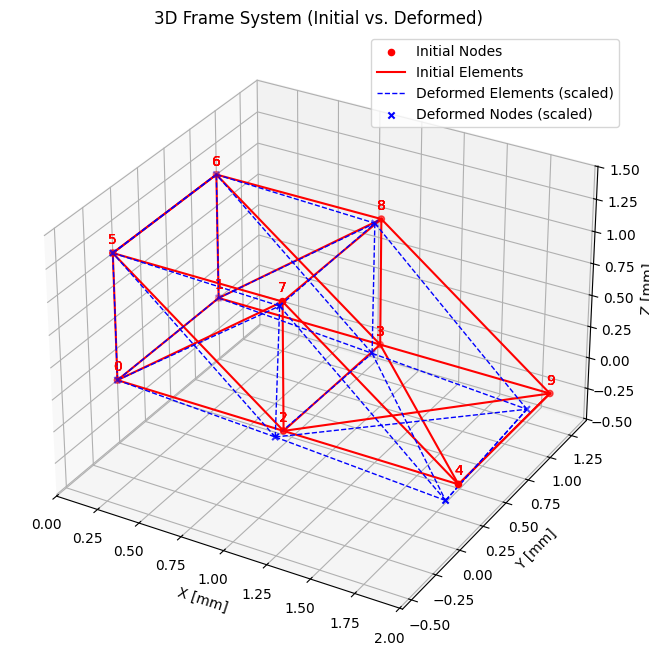

In [8]:
# --- Define Material and Cross-sectional Properties ---
E = 210e3 
A = 100  
I_y = 1000 
I_z = 1000 
J = 50  
x_axis = np.array([1, 0, 0])

# --- Create Frame Elements based on connectivity ---
elements = []
nodal_coordinates = np.array(data["nodal_coordinates"])
for i, conn in enumerate(data["connectivity"]):
    node1_idx, node2_idx = conn
    node_coords = [nodal_coordinates[node1_idx], nodal_coordinates[node2_idx]]

    p1 = np.array(node_coords[0])
    p2 = np.array(node_coords[1])
    element_length = np.linalg.norm(p2 - p1)

    element_vector = p2 - p1
    dot_product = np.dot(element_vector, x_axis)
    element_length = np.linalg.norm(element_vector)
    angle_rad = np.arccos(dot_product / element_length)
    angle_deg = np.degrees(angle_rad)


    element = FrameElement3D(
        node_indices=conn,
        node_coordinates=node_coords,
        E=E, A=A, L=element_length, I_y=I_y, I_z=I_z, J=J, theta_x=angle_deg)
    elements.append(element)

# --- Define External Forces and Moments ---
forces = {}
# Each entry is [Fx, Fy, Fz, Mx, My, Mz]
for load_node_idx in data["load_nodes"]:
    forces[load_node_idx] = [0, -900000, 0, 0, 0, 0]

boundary_conditions = {}
for fixed_node_idx in data["fixed_nodes"]:
    boundary_conditions[fixed_node_idx] = [True, True, True, True, True, True]

num_nodes = len(nodal_coordinates)
frame_system = FrameSystem3D(elements, num_nodes, forces, boundary_conditions)

print("\n--- Assembling and Solving System ---")
displacements = frame_system.solve()

if displacements is not None:
    print("\nGlobal Displacements (ux, uy, uz, rx, ry, rz per node):")
    for i in range(num_nodes):
        node_disps = displacements[i*6 : i*6 + 6]
        print(f"Node {i}: ux={node_disps[0]:.4e}, uy={node_disps[1]:.4e}, uz={node_disps[2]:.4e}, "
              f"rx={np.degrees(node_disps[3]):.4f}°, ry={np.degrees(node_disps[4]):.4f}°, rz={np.degrees(node_disps[5]):.4f}°")

    print("\n--- Plotting Results ---")
    plotter = Plotter3D(frame_system)
    plotter.plot_system(scale_factor=500)
else:
    print("System could not be solved due to a singularity or other numerical issue.")

